# Tests of the Adiabatic Iteration Procedure (aka. Young's Method)
Here we check that individual iterations of Young's Method work reliably with our Code

This notebook is here for verification purposes and it is not recommended that you deal with this unless you are really interested in the details

Here we will check:

1) That we can recover a known density profile through integration of its phase space density distribution

2) That a single adiabatic iteration make qualitative sense

3) That the procedure works for many iterations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ColorConverter

import sys

import numpy as np
sys.path.append("../..")
import adiabatic_tides as at

# Reconstruction of an NFW through phasespace integration

Here we check that we indeed recover the correct real space density when we do integrate the phase space density

   $$
   \begin{align}
    \rho(r) &= \int \int \int f(\vec{x},\vec{v}) \rm{d}^3 v\\ 
            &= 4 \pi \int_{\phi(r)}^{E_{\rm{max}}(r)} \int_{L_{\rm{min}}(r,E)}^{L_{\rm{max}}(r,E)} \frac{L f(E, L)}{r^2 u(r,E,L)} \rm{d}L \rm{d}E  \label{eqn:f_to_dens}
   \end{align}
   $$

1) When directly using the correct phase space density f(E). (This tests the accuracy of the phase space integrator and of the phase space distribution function f(E))

2) When using the interpolators matching it to the initial profile f(E,L) = f0(E(J(E,L),L), L)
   (This tests additionally the accuracy of all interpolation steps that are used in the adiabatic iterations)
   
For more details, see the function: 
```
adiabatic_tides.profiles.AdiabaticProfile.rho_from_f
```

CPU times: user 7.49 s, sys: 283 ms, total: 7.77 s
Wall time: 7.74 s


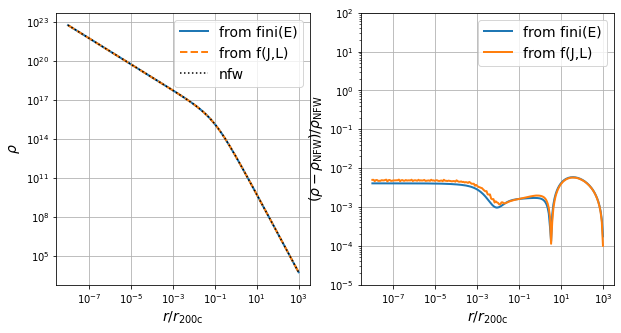

In [2]:
%%time
nfw = at.profiles.NFWProfile(conc=10., m200c=1e9)
prof_ad = at.profiles.AdiabaticProfile(nfw, tidfac_rvir=1e-25, nbins=500)

fig, axs = plt.subplots(1,2, figsize=(10,5))

ri = np.logspace(-8, 3, 201) * nfw.r200c    

rho_ini = prof_ad.rho_from_f(ri, use_initial=True)
rho_ad = prof_ad.rho_from_f(ri, use_initial=False)

axs[0].loglog(ri/nfw.r200c, rho_ini, lw=2, label="from fini(E)")
axs[0].loglog(ri/nfw.r200c, rho_ad, lw=2, linestyle="dashed", label="from f(J,L)")
axs[0].loglog(ri/nfw.r200c, nfw.density(ri), linestyle="dotted", color="black", label="nfw")

axs[1].semilogx(ri/nfw.r200c, np.abs(1.-rho_ini / nfw.density(ri)), label="from fini(E)", lw=2)
axs[1].semilogx(ri/nfw.r200c, np.abs(1.-rho_ad / nfw.density(ri)), label="from f(J,L)", lw=2)

axs[1].set_ylim(1e-5,1e2)
axs[1].loglog()

axs[0].set_ylabel(r"$\rho$", fontsize=14)
axs[1].set_ylabel(r"$(\rho - \rho_{\rm{NFW}})/\rho_{\rm{NFW}}$", fontsize=14)

for ax in axs:
    ax.grid("on")
    ax.legend(fontsize=14)
    ax.set_xlabel(r"$r / r_{\rm{200c}}$", fontsize=14)

=> We can recover the density profile to more than 1% accuracy over an enormous spatial range!

# First adiabatic Iteration

Here we check the result of one adiabatic iteration. That is we calculate $\rho$ from $f(J,L)$, but where we calculated the actions in the potential including the tidal field
$$
\begin{align}
\phi_1(r) = \phi_0(r) - \frac{1}{2} \lambda r^2
\end{align}
$$

In [3]:
%%time
nfw = at.profiles.NFWProfile(conc=10., m200c=1e9)
profs = {}
dens = {}
ri = np.logspace(-4., 1., 200) * nfw.r200c
for lam in 256.,64.,16.,4.,1.,0.25:
    print(lam)
    profs[lam] = at.profiles.AdiabaticProfile(nfw, tidfac_rvir=lam)
    dens[lam] = profs[lam].rho_from_f(ri)

256.0
64.0
16.0
4.0
1.0
0.25
CPU times: user 18.6 s, sys: 227 ms, total: 18.8 s
Wall time: 18.7 s


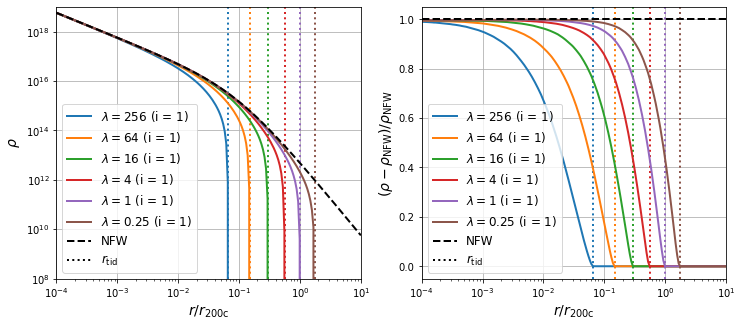

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
for lam in profs:
    prof_ad, rho_ad = profs[lam], dens[lam]
    label = r"$\lambda = %g$ (i = 1)" % lam
    axs[0].loglog(ri/nfw.r200c, rho_ad, label=label, lw=2)
    p = axs[1].semilogx(ri/nfw.r200c, rho_ad/nfw.density(ri), lw=2, label=label)
    for ax in axs:
        ax.axvline(prof_ad._rtid/nfw.r200c, linestyle="dotted", lw=2, color=p[0].get_color())

axs[0].loglog(ri/nfw.r200c, nfw.density(ri), linestyle="dashed",color="black", label="NFW", lw=2)
axs[1].axhline(1., linestyle="dashed",color="black", label="NFW", lw=2)

axs[0].set_ylabel(r"$\rho$", fontsize=14)
axs[1].set_ylabel(r"$(\rho - \rho_{\rm{NFW}})/\rho_{\rm{NFW}}$", fontsize=14)
axs[0].set_ylim(1e8, 1e19)

for ax in axs:
    ax.plot([], linestyle="dotted", color="black", lw=2, label=r"$r_{\rm{tid}}$")
    ax.set_xlim(1e-4,1e1)
    ax.grid("on")
    ax.legend(loc="lower left", fontsize=12)
    ax.set_xlabel(r"$r / r_{\rm{200c}}$", fontsize=14)

# Check other functions after 1 iteration
Here again do a single iteration. However, we also use the interpolators of at.profiles.AdiabaticProfile and check whether all reconstructed functions (density, potential, acceleration, enclosed mass) make sense

For more, check:
```
adiabatic_tides.profiles.AdiabaticProfile.rho_from_f
adiabatic_tides.profiles.AdiabaticProfile._update_profile
```

In [5]:
lam=1.
nfw = at.profiles.NFWProfile(conc=10., m200c=1e9)
prof_ad = at.profiles.AdiabaticProfile(nfw, tidfac_rvir=lam, nbins=200)
prof_ad._initialize_tidal_radius()
rinew = np.logspace(np.log10(1e-12*nfw.r200c), np.log10( np.min((prof_ad._rtid+1e-8, nfw.r200c*1e3) )), 201)
rhonew = prof_ad.rho_from_f(rinew)
prof_ad.reset_interpolators()
prof_ad._update_profile(rinew, rhonew)

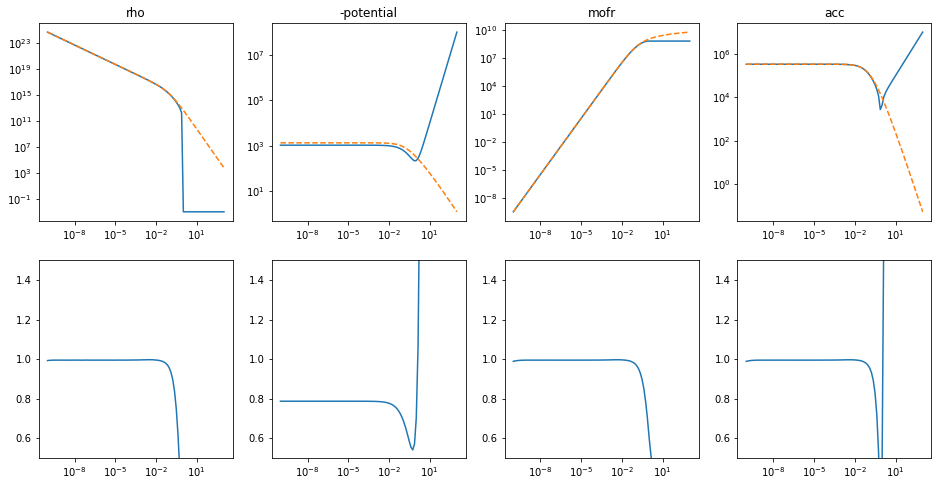

In [6]:
fig, axs = plt.subplots(2, 4, figsize=(16,8))
ri = np.logspace(-10, 3, 101) * nfw.r200c

axs[0,0].set_title("rho")
axs[0,1].set_title("-potential")
axs[0,2].set_title("mofr")
axs[0,3].set_title("acc")

#for prof, ls in zip((nfw, prof_ad), ("solid", "dashed")):
axs[0,0].loglog(ri/nfw.r200c, prof_ad.self_density(ri), linestyle="solid", label="1 iteration")
axs[0,1].loglog(ri/nfw.r200c, -prof_ad.potential(ri), linestyle="solid", label="1 iteration")
axs[0,2].loglog(ri/nfw.r200c, prof_ad.self_m_of_r(ri), linestyle="solid", label="1 iteration")
axs[0,3].loglog(ri/nfw.r200c, np.abs(prof_ad.accr(ri)), linestyle="solid", label="1 iteration")

axs[0,0].loglog(ri/nfw.r200c, nfw.density(ri), linestyle="dashed", label="NFW")
axs[0,1].loglog(ri/nfw.r200c, -nfw.potential(ri), linestyle="dashed", label="NFW")
axs[0,2].loglog(ri/nfw.r200c, nfw.m_of_r(ri), linestyle="dashed", label="NFW")
axs[0,3].loglog(ri/nfw.r200c, np.abs(nfw.accr(ri)), linestyle="dashed", label="NFW")

dphi = nfw.potential(ri[-1:]) - prof_ad.potential(ri[-1:])
axs[1,0].semilogx(ri/nfw.r200c, np.abs(prof_ad.self_density(ri)/nfw.density(ri)))
axs[1,1].semilogx(ri/nfw.r200c, np.abs((prof_ad.potential(ri))/nfw.potential(ri)))
axs[1,2].semilogx(ri/nfw.r200c, np.abs(prof_ad.self_m_of_r(ri)/nfw.m_of_r(ri)))
axs[1,3].semilogx(ri/nfw.r200c, np.abs(prof_ad.accr(ri)/nfw.accr(ri)))

for ax in axs[1,:]:
    ax.set_ylim(0.5,1.5)

# Note that all functions approach the original value in the centre, except for the potential
# This is correct, since an absolute in the potential has no dynamical effect

# Several iterations

Here we do the same as above, but using the output after n iterations to infer a new profile for n+1 iterations

Note that here we do the steps explicitly, but adiabatic_tides.profiles.AdiabaticProfile can do most of these things "under the hood", e.g.
```
adiabatic_tides.profiles.AdiabaticProfile(..., niter=*)
adiabatic_tides.profiles.AdiabaticProfile.iterate
```

In [7]:
lam = 16.
nfw = at.profiles.NFWProfile(conc=10., m200c=1e9)
prof_ad = at.profiles.AdiabaticProfile(nfw, tidfac_rvir=lam, nbins=150)
prof_ad._initialize_tidal_radius()

import time

rhos = {}
for i in range(0,50):
    t0 = time.time()
    rinew = np.logspace(np.log10(1e-12*nfw.r200c), np.log10(prof_ad._rtid*(1.+1e-8)), 100)
    rhonew = prof_ad.rho_from_f(rinew)
    prof_ad.reset_interpolators()
    prof_ad._update_profile(rinew, rhonew)
    print("i=%d, mfrac=%g, dt=%.1fs" % (i, prof_ad.self_m_of_r(nfw.r200c) / nfw.m200c, time.time()-t0))
    
    rhos[i] = prof_ad.self_density(ri)

i=0, mfrac=0.180177, dt=5.6s
i=1, mfrac=0.105133, dt=1.9s
i=2, mfrac=0.0721376, dt=2.0s
i=3, mfrac=0.0533548, dt=2.1s
i=4, mfrac=0.0412805, dt=2.1s
i=5, mfrac=0.0330811, dt=2.1s
i=6, mfrac=0.0272796, dt=2.0s
i=7, mfrac=0.0230139, dt=2.0s
i=8, mfrac=0.0197901, dt=1.9s
i=9, mfrac=0.0173, dt=1.9s
i=10, mfrac=0.0153416, dt=1.9s
i=11, mfrac=0.0137779, dt=1.8s
i=12, mfrac=0.012513, dt=1.8s
i=13, mfrac=0.011478, dt=1.8s
i=14, mfrac=0.0106225, dt=1.8s
i=15, mfrac=0.00990908, dt=1.8s
i=16, mfrac=0.00930958, dt=1.7s
i=17, mfrac=0.00880233, dt=1.7s
i=18, mfrac=0.00837047, dt=1.7s
i=19, mfrac=0.00800066, dt=1.7s
i=20, mfrac=0.00768244, dt=1.7s
i=21, mfrac=0.00740733, dt=1.7s
i=22, mfrac=0.0071685, dt=1.6s
i=23, mfrac=0.00696038, dt=1.6s
i=24, mfrac=0.00677836, dt=1.6s
i=25, mfrac=0.00661879, dt=1.6s
i=26, mfrac=0.00647855, dt=1.6s
i=27, mfrac=0.00635501, dt=1.6s
i=28, mfrac=0.00624595, dt=1.6s
i=29, mfrac=0.00614949, dt=1.6s
i=30, mfrac=0.00606402, dt=1.6s
i=31, mfrac=0.00598816, dt=1.6s
i=32, mfr

CPU times: user 168 ms, sys: 4.17 ms, total: 172 ms
Wall time: 170 ms


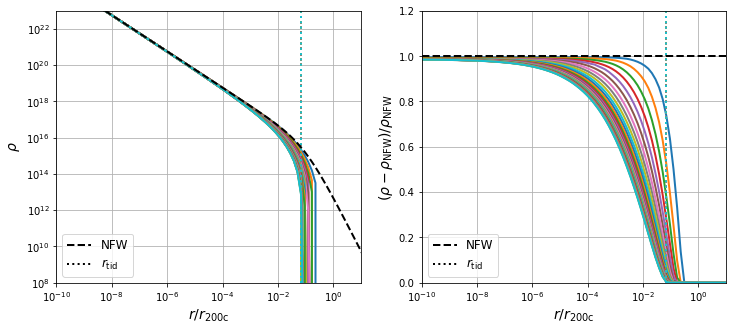

In [8]:
%%time

fig, axs = plt.subplots(1, 2, figsize=(12,5))

for i in range(0,30):#rhos.keys():
    rho_ad = rhos[i]
    #label = r"$\lambda = %g$ (i = %d)" % (1., i)
    label = None
    axs[0].loglog(ri/nfw.r200c, rho_ad, label=label, lw=2)
    p = axs[1].semilogx(ri/nfw.r200c, rho_ad/nfw.density(ri), lw=2, label=label)
    for ax in axs:
        ax.axvline(prof_ad._rtid/nfw.r200c, linestyle="dotted", lw=2, color=p[0].get_color())

axs[0].loglog(ri/nfw.r200c, nfw.density(ri), linestyle="dashed",color="black", label="NFW", lw=2)
axs[1].axhline(1., linestyle="dashed",color="black", label="NFW", lw=2)

axs[0].set_ylabel(r"$\rho$", fontsize=14)
axs[1].set_ylabel(r"$(\rho - \rho_{\rm{NFW}})/\rho_{\rm{NFW}}$", fontsize=14)
axs[0].set_ylim(1e8, 1e23)
axs[1].set_ylim(0,1.2)

for ax in axs:
    ax.plot([], linestyle="dotted", color="black", lw=2, label=r"$r_{\rm{tid}}$")
    ax.set_xlim(1e-10,1e1)
    ax.grid("on")
    ax.legend(loc="lower left", fontsize=12)
    ax.set_xlabel(r"$r / r_{\rm{200c}}$", fontsize=14)